In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer #Habilitar el IterativeImputer
from sklearn.impute import IterativeImputer, KNNImputer # Imputar los datos faltantes 
# Prepocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import category_encoders as ce
#Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold #Para ajustar el cv en el cross validation 
from sklearn.model_selection import validation_curve # Ver la curva de validaction (Tunning de parametros)
from sklearn.model_selection import learning_curve # Curva de aprendizaje(Ver si el modelo esta prendiendo)
from sklearn.model_selection import GridSearchCV
# Model
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#Features
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest # Seleccionar las k mejores features
from sklearn.feature_selection import mutual_info_regression #Metrica para seleccionar las mejores features

import re

In [89]:
df = pd.read_csv('data/peliculas.csv', encoding='utf-8')
df.head()

,movie_title,title_year,color,aspect_ratio,duration,language,country,duration.1,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
0,Avatar,2009.0,Color,1.78,178.0,English,USA,178.0,Action|Adventure|Fantasy|Sci-Fi,PG-13,avatar|future|marine|native|paraplegic,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,4834,237000000.0,7.9,760505847.0
1,Pirates of the Caribbean: At World's End,2007.0,Color,2.35,169.0,English,USA,169.0,Action|Adventure|Fantasy,PG-13,goddess|marriage ceremony|marriage proposal|pi...,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,48350,300000000.0,7.1,309404152.0
2,Spectre,2015.0,Color,2.35,148.0,English,UK,148.0,Action|Adventure|Thriller,PG-13,bomb|espionage|sequel|spy|terrorist,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,11700,245000000.0,6.8,200074175.0
3,The Dark Knight Rises,2012.0,Color,2.35,164.0,English,USA,164.0,Action|Thriller,PG-13,deception|imprisonment|lawlessness|police offi...,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,106759,250000000.0,8.5,448130642.0
4,Star Wars: Episode VII - The Force Awakens ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Documentary,NaN,NaN,Doug Walker,Doug Walker,Rob Walker,NaN,143,NaN,7.1,NaN


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   movie_title                5043 non-null   object 
 1   title_year                 4935 non-null   float64
 2   color                      5024 non-null   object 
 3   aspect_ratio               4714 non-null   float64
 4   duration                   5028 non-null   float64
 5   language                   5031 non-null   object 
 6   country                    5038 non-null   object 
 7   duration.1                 5028 non-null   float64
 8   genres                     5043 non-null   object 
 9   content_rating             4740 non-null   object 
 10  plot_keywords              4890 non-null   object 
 11  director_name              4939 non-null   object 
 12  actor_1_name               5036 non-null   object 
 13  actor_2_name               5030 non-null   objec

In [91]:
df.describe()

,title_year,aspect_ratio,duration,duration.1,cast_total_facebook_likes,budget,imdb_score,gross
count,4935.000000,4714.000000,5028.000000,5028.000000,5043.000000,4.551000e+03,5043.000000,4.159000e+03
mean,2002.470517,2.220403,107.201074,107.201074,9699.063851,3.975262e+07,6.442138,4.846841e+07
std,12.474599,1.385113,25.197441,25.197441,18163.799124,2.061149e+08,1.125116,6.845299e+07
min,1916.000000,1.180000,7.000000,7.000000,0.000000,2.180000e+02,1.600000,1.620000e+02
25%,1999.000000,1.850000,93.000000,93.000000,1411.000000,6.000000e+06,5.800000,5.340988e+06
50%,2005.000000,2.350000,103.000000,103.000000,3090.000000,2.000000e+07,6.600000,2.551750e+07
75%,2011.000000,2.350000,118.000000,118.000000,13756.500000,4.500000e+07,7.200000,6.230944e+07
max,2016.000000,16.000000,511.000000,511.000000,656730.000000,1.221550e+10,9.500000,7.605058e+08


# *Limpieza*

In [92]:
df['movie_title'] = df['movie_title'].apply(lambda x : x.replace('\xa0',''))

In [93]:
del df['duration.1']

## Datos Repetidos

In [94]:
drop_index = df[df[['movie_title','title_year']].duplicated()].index

In [95]:
df.drop(drop_index, axis=0, inplace=True)

## Datos faltantes

In [96]:
df.isna().sum()

movie_title                    0
title_year                   106
color                         19
aspect_ratio                 326
duration                      15
language                      12
country                        5
genres                         0
content_rating               301
plot_keywords                152
director_name                102
actor_1_name                   7
actor_2_name                  13
actor_3_name                  23
cast_total_facebook_likes      0
budget                       485
imdb_score                     0
gross                        863
dtype: int64

In [97]:
columns_types = (df.dtypes == 'float64') | (df.dtypes.str.startswith('int'))
num_columns = [x for x in columns_types.keys() if columns_types[x] == True]
str_columns = [x for x in columns_types.keys() if columns_types[x] == False]

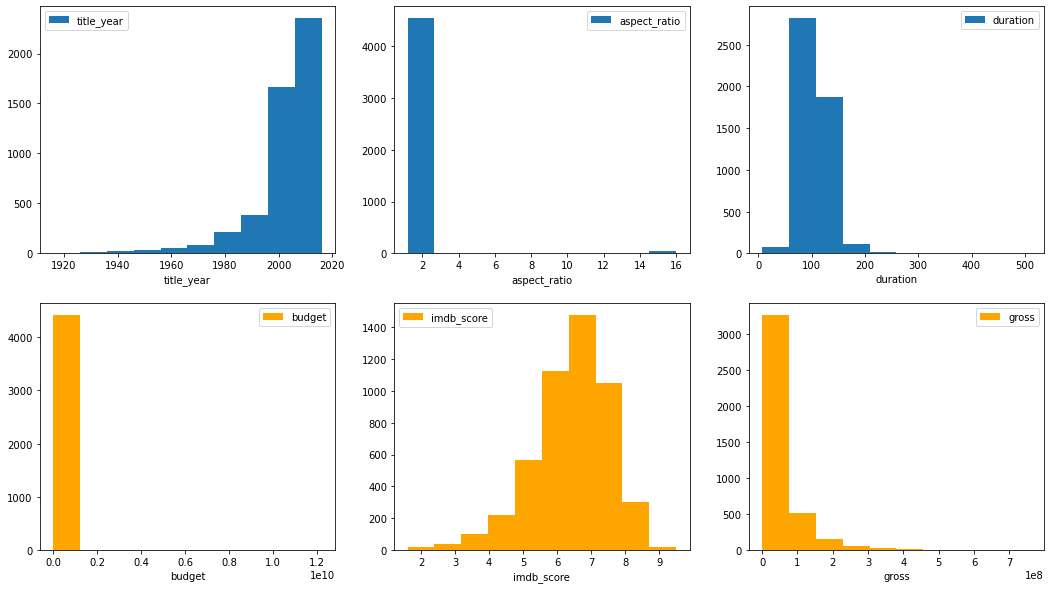

In [98]:
fig, ax = plt.subplots(2,3, figsize = (18,10))

for idx, i in enumerate(num_columns):
    if idx < 3:
        ax[0,idx].hist(df[i], label = i)
        ax[0,idx].set_xlabel(i)
        ax[0,idx].legend()
    elif idx >= 3:
        idx -= 3
        ax[1,idx].hist(df[i], label = i, color='orange')
        ax[1,idx].set_xlabel(i)
        ax[1,idx].legend()

In [99]:
df[df['gross'] > 4*100000000].head()

,movie_title,title_year,color,aspect_ratio,duration,language,country,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
0,Avatar,2009.0,Color,1.78,178.0,English,USA,Action|Adventure|Fantasy|Sci-Fi,PG-13,avatar|future|marine|native|paraplegic,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,4834,237000000.0,7.9,760505847.0
3,The Dark Knight Rises,2012.0,Color,2.35,164.0,English,USA,Action|Thriller,PG-13,deception|imprisonment|lawlessness|police offi...,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,106759,250000000.0,8.5,448130642.0
8,Avengers: Age of Ultron,2015.0,Color,2.35,141.0,English,USA,Action|Adventure|Sci-Fi,PG-13,artificial intelligence|based on comic book|ca...,Joss Whedon,Chris Hemsworth,Robert Downey Jr.,Scarlett Johansson,92000,250000000.0,7.5,458991599.0
13,Pirates of the Caribbean: Dead Man's Chest,2006.0,Color,2.35,151.0,English,USA,Action|Adventure|Fantasy,PG-13,box office hit|giant squid|heart|liar's dice|m...,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,48486,225000000.0,7.3,423032628.0
17,The Avengers,2012.0,Color,1.85,173.0,English,USA,Action|Adventure|Sci-Fi,PG-13,alien invasion|assassin|battle|iron man|soldier,Joss Whedon,Chris Hemsworth,Robert Downey Jr.,Scarlett Johansson,87697,220000000.0,8.1,623279547.0


In [100]:
df[df['budget'] > 0.2 * 10000000000]

,movie_title,title_year,color,aspect_ratio,duration,language,country,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
2323,Princess Mononoke,1997.0,Color,1.85,134.0,Japanese,Japan,Adventure|Animation|Fantasy,PG-13,anime|cult film|forest|princess|studio ghibli,Hayao Miyazaki,Minnie Driver,Jada Pinkett Smith,Billy Crudup,2710,2.400000e+09,8.4,2298191.0
2334,Steamboy,2004.0,Color,1.85,103.0,Japanese,Japan,Action|Adventure|Animation|Family|Sci-Fi|Thriller,PG-13,19th century|ball|boy|inventor|steam,Katsuhiro Ôtomo,William Hootkins,Robin Atkin Downes,Rosalind Ayres,991,2.127520e+09,6.9,410388.0
2988,The Host,2006.0,Color,1.85,110.0,Korean,South Korea,Comedy|Drama|Horror|Sci-Fi,R,daughter|han river|monster|river|seoul,Joon-ho Bong,Doona Bae,Kang-ho Song,Ah-sung Ko,1173,1.221550e+10,7.0,2201412.0
3005,Fateless,2005.0,Color,2.35,134.0,Hungarian,Hungary,Drama|Romance|War,R,bus|death|gay slur|hatred|jewish,Lajos Koltai,Marcell Nagy,Péter Fancsikai,Bálint Péntek,11,2.500000e+09,7.1,195888.0
3859,Lady Vengeance,2005.0,Color,2.35,112.0,Korean,South Korea,Crime|Drama,R,cake|christian|lesbian sex|oral sex|pregnant s...,Chan-wook Park,Min-sik Choi,Yeong-ae Lee,Hye-jeong Kang,907,4.200000e+09,7.7,211667.0


El problema con los datos de las monedas en este dataset es que no todas están en la misma moneda, por lo que hay outliers.
Por lo que se tomó la decisión de extraer información de https://www.the-numbers.com/ para solucionar este problema

In [101]:
df_numbers =pd.read_csv('./data/thenumbers.csv',index_col='Unnamed: 0')
df_numbers.drop(columns='movie_title', axis=1, inplace=True)
df_numbers.head()

,movie_name,domestic_gross,movie_link,production_budget,release_date,worldwide_gross
0,Avatar,760507625,http://www.the-numbers.com/movie/Avatar#tab=su...,425000000,12/18/2009,2783918982
1,Star Wars Ep. VII: The Force Awakens,936662225,http://www.the-numbers.com/movie/Star-Wars-Ep-...,306000000,12/18/2015,2058662225
2,Pirates of the Caribbean: At World's End,309420425,http://www.the-numbers.com/movie/Pirates-of-th...,300000000,5/24/2007,963420425
3,Spectre,200074175,http://www.the-numbers.com/movie/Spectre#tab=s...,300000000,11/6/2015,879620923
4,The Dark Knight Rises,448139099,http://www.the-numbers.com/movie/Dark-Knight-R...,275000000,7/20/2012,1084439099


In [102]:
df[df['movie_title'] == 'The Host']

,movie_title,title_year,color,aspect_ratio,duration,language,country,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
1002,The Host,2013.0,Color,2.35,125.0,English,USA,Action|Adventure|Romance|Sci-Fi|Thriller,PG-13,alien|alien creature|body snatching|desert|par...,Andrew Niccol,J.D. Evermore,Chandler Canterbury,Rachel Roberts,1300,4.000000e+07,5.9,26616999.0
2988,The Host,2006.0,Color,1.85,110.0,Korean,South Korea,Comedy|Drama|Horror|Sci-Fi,R,daughter|han river|monster|river|seoul,Joon-ho Bong,Doona Bae,Kang-ho Song,Ah-sung Ko,1173,1.221550e+10,7.0,2201412.0


In [103]:
df_numbers[df_numbers['movie_name'] == 'The Host']

,movie_name,domestic_gross,movie_link,production_budget,release_date,worldwide_gross
1027,The Host,26623701,http://www.the-numbers.com/movie/Host-The#tab=...,50000000,3/29/2013,64477051


Hacer un merge entre los dos datasets

In [104]:
df_numbers['release_date'] = pd.to_datetime(df_numbers['release_date'])
df_numbers['title_year'] = df_numbers['release_date'].dt.year

df_numbers.rename(columns={'movie_name':'movie_title'}, inplace=True) # Cambiarle en nombre a la columna 
df = pd.merge(df_numbers, df, on=['movie_title','title_year'], how='left')
df.head()

,movie_title,domestic_gross,movie_link,production_budget,release_date,worldwide_gross,title_year,color,aspect_ratio,duration,...,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
0,Avatar,760507625,http://www.the-numbers.com/movie/Avatar#tab=su...,425000000,2009-12-18,2783918982,2009,Color,1.78,178.0,...,PG-13,avatar|future|marine|native|paraplegic,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,4834.0,237000000.0,7.9,760505847.0
1,Star Wars Ep. VII: The Force Awakens,936662225,http://www.the-numbers.com/movie/Star-Wars-Ep-...,306000000,2015-12-18,2058662225,2015,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Pirates of the Caribbean: At World's End,309420425,http://www.the-numbers.com/movie/Pirates-of-th...,300000000,2007-05-24,963420425,2007,Color,2.35,169.0,...,PG-13,goddess|marriage ceremony|marriage proposal|pi...,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,48350.0,300000000.0,7.1,309404152.0
3,Spectre,200074175,http://www.the-numbers.com/movie/Spectre#tab=s...,300000000,2015-11-06,879620923,2015,Color,2.35,148.0,...,PG-13,bomb|espionage|sequel|spy|terrorist,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,11700.0,245000000.0,6.8,200074175.0
4,The Dark Knight Rises,448139099,http://www.the-numbers.com/movie/Dark-Knight-R...,275000000,2012-07-20,1084439099,2012,Color,2.35,164.0,...,PG-13,deception|imprisonment|lawlessness|police offi...,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,106759.0,250000000.0,8.5,448130642.0


## Eliminar los datos faltantes en la variable a predecir

In [105]:
df.isnull().sum()

movie_title                     0
domestic_gross                  0
movie_link                      0
production_budget               0
release_date                    0
worldwide_gross                 0
title_year                      0
color                        1033
aspect_ratio                 1160
duration                     1036
language                     1034
country                      1028
genres                       1028
content_rating               1113
plot_keywords                1081
director_name                1028
actor_1_name                 1031
actor_2_name                 1031
actor_3_name                 1034
cast_total_facebook_likes    1028
budget                       1195
imdb_score                   1028
gross                        1384
dtype: int64

In [106]:
avaliable_data = ((df != 0) & (df.notnull())) # Son los datos que no son nulos y que son diferentes a 0
avaliable_data.all(axis = 1).value_counts()

True     2764
False    1577
dtype: int64

In [107]:
gross_filter = avaliable_data['worldwide_gross']
df = df[gross_filter]

((df != 0) & (df.notnull())).worldwide_gross.value_counts()

True    4061
Name: worldwide_gross, dtype: int64

## Eliminar los datos faltantes en el resto del dataset

In [108]:
df.head()

,movie_title,domestic_gross,movie_link,production_budget,release_date,worldwide_gross,title_year,color,aspect_ratio,duration,...,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
0,Avatar,760507625,http://www.the-numbers.com/movie/Avatar#tab=su...,425000000,2009-12-18,2783918982,2009,Color,1.78,178.0,...,PG-13,avatar|future|marine|native|paraplegic,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,4834.0,237000000.0,7.9,760505847.0
1,Star Wars Ep. VII: The Force Awakens,936662225,http://www.the-numbers.com/movie/Star-Wars-Ep-...,306000000,2015-12-18,2058662225,2015,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Pirates of the Caribbean: At World's End,309420425,http://www.the-numbers.com/movie/Pirates-of-th...,300000000,2007-05-24,963420425,2007,Color,2.35,169.0,...,PG-13,goddess|marriage ceremony|marriage proposal|pi...,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,48350.0,300000000.0,7.1,309404152.0
3,Spectre,200074175,http://www.the-numbers.com/movie/Spectre#tab=s...,300000000,2015-11-06,879620923,2015,Color,2.35,148.0,...,PG-13,bomb|espionage|sequel|spy|terrorist,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,11700.0,245000000.0,6.8,200074175.0
4,The Dark Knight Rises,448139099,http://www.the-numbers.com/movie/Dark-Knight-R...,275000000,2012-07-20,1084439099,2012,Color,2.35,164.0,...,PG-13,deception|imprisonment|lawlessness|police offi...,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,106759.0,250000000.0,8.5,448130642.0


In [109]:
columns_types = (df.dtypes == 'float64') | (df.dtypes == 'int64')
num_columns = [x for x in columns_types.keys() if columns_types[x] == True]
str_columns = [x for x in columns_types.keys() if columns_types[x] == False]

num_columns

['domestic_gross',
 'production_budget',
 'worldwide_gross',
 'title_year',
 'aspect_ratio',
 'duration',
 'cast_total_facebook_likes',
 'budget',
 'imdb_score',
 'gross']

In [110]:
X = df[num_columns]

impute = IterativeImputer()

columns = X.columns
index = X.index

X = impute.fit_transform(X)

X = pd.DataFrame(X, index=index, columns=columns)
X.head()

,domestic_gross,production_budget,worldwide_gross,title_year,aspect_ratio,duration,cast_total_facebook_likes,budget,imdb_score,gross
0,760507625.0,425000000.0,2.783919e+09,2009.0,1.780000,178.000000,4834.000000,2.370000e+08,7.900000,7.605058e+08
1,936662225.0,306000000.0,2.058662e+09,2015.0,2.312654,169.605416,57890.356292,2.958969e+08,10.580024,9.210393e+08
2,309420425.0,300000000.0,9.634204e+08,2007.0,2.350000,169.000000,48350.000000,3.000000e+08,7.100000,3.094042e+08
3,200074175.0,300000000.0,8.796209e+08,2015.0,2.350000,148.000000,11700.000000,2.450000e+08,6.800000,2.000742e+08
4,448139099.0,275000000.0,1.084439e+09,2012.0,2.350000,164.000000,106759.000000,2.500000e+08,8.500000,4.481306e+08


In [111]:
X.isna().sum()

domestic_gross               0
production_budget            0
worldwide_gross              0
title_year                   0
aspect_ratio                 0
duration                     0
cast_total_facebook_likes    0
budget                       0
imdb_score                   0
gross                        0
dtype: int64

In [112]:
df[num_columns] = X

df.head()

,movie_title,domestic_gross,movie_link,production_budget,release_date,worldwide_gross,title_year,color,aspect_ratio,duration,...,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
0,Avatar,760507625.0,http://www.the-numbers.com/movie/Avatar#tab=su...,425000000.0,2009-12-18,2.783919e+09,2009.0,Color,1.780000,178.000000,...,PG-13,avatar|future|marine|native|paraplegic,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,4834.000000,2.370000e+08,7.900000,7.605058e+08
1,Star Wars Ep. VII: The Force Awakens,936662225.0,http://www.the-numbers.com/movie/Star-Wars-Ep-...,306000000.0,2015-12-18,2.058662e+09,2015.0,NaN,2.312654,169.605416,...,NaN,NaN,NaN,NaN,NaN,NaN,57890.356292,2.958969e+08,10.580024,9.210393e+08
2,Pirates of the Caribbean: At World's End,309420425.0,http://www.the-numbers.com/movie/Pirates-of-th...,300000000.0,2007-05-24,9.634204e+08,2007.0,Color,2.350000,169.000000,...,PG-13,goddess|marriage ceremony|marriage proposal|pi...,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,48350.000000,3.000000e+08,7.100000,3.094042e+08
3,Spectre,200074175.0,http://www.the-numbers.com/movie/Spectre#tab=s...,300000000.0,2015-11-06,8.796209e+08,2015.0,Color,2.350000,148.000000,...,PG-13,bomb|espionage|sequel|spy|terrorist,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,11700.000000,2.450000e+08,6.800000,2.000742e+08
4,The Dark Knight Rises,448139099.0,http://www.the-numbers.com/movie/Dark-Knight-R...,275000000.0,2012-07-20,1.084439e+09,2012.0,Color,2.350000,164.000000,...,PG-13,deception|imprisonment|lawlessness|police offi...,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,106759.000000,2.500000e+08,8.500000,4.481306e+08


# *Standarization*

In [113]:
scaling = StandardScaler()

num_columns.remove('worldwide_gross')

X = df[num_columns]

X_scaled = scaling.fit_transform(X)

X = pd.DataFrame(X_scaled, columns= X.columns, index=X.index)

df[num_columns] = X

# *Modelo*

In [114]:
num_columns

['domestic_gross',
 'production_budget',
 'title_year',
 'aspect_ratio',
 'duration',
 'cast_total_facebook_likes',
 'budget',
 'imdb_score',
 'gross']

In [115]:
X = df[num_columns]
y = df['worldwide_gross']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [116]:
lr = Lasso(max_iter=100000)

model = lr.fit(X_train,y_train)
predict = model.predict(X_test)

print('MSE :',mean_squared_error(predict,y_test))

MSE : 2906287546202247.0


In [117]:
model.score(X_test,y_test)

0.923204817569749

In [118]:
linear_r = LinearRegression().fit(X_train,y_train)
predict_linear = linear_r.predict(X_test)
print('MSE :',mean_squared_error(predict_linear,y_test))

MSE : 2906287540737645.0


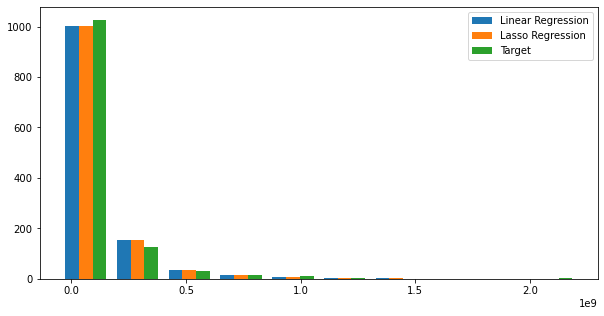

In [119]:
plt.figure(figsize=(10,5))
plt.hist([predict_linear,predict,y_test], label=['Linear Regression','Lasso Regression','Target'])
plt.legend()
plt.show()

## Residuales

Son la diferencia que hay entre la prediccion y el valor real

In [120]:
residual = y_test - predict

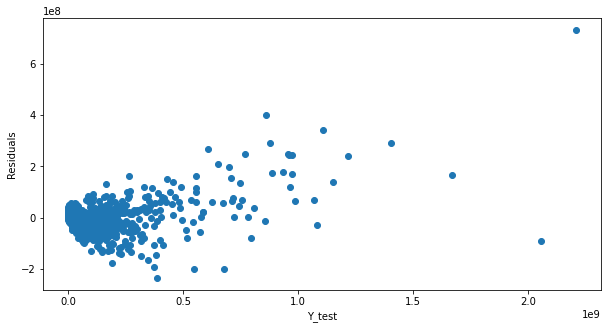

In [121]:
plt.figure(figsize=(10,5))
plt.scatter(y_test,residual)
plt.xlabel('Y_test')
plt.ylabel('Residuals');

In [122]:
ap_residuals = np.abs(residual) / y_test

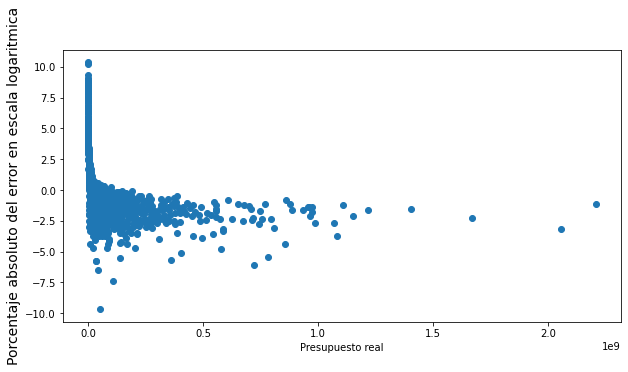

In [123]:
lap_residuals = np.log(ap_residuals) # usamos una escala logaritmica para poder ver los datos mas compactados y en orden de magnitud.
plt.figure(figsize=(10,5))
plt.scatter(y_test,lap_residuals)
plt.xlabel('Presupuesto real')
plt.ylabel('Porcentaje absoluto del error en escala logaritmica', fontsize = 14);

Para mejorar este resultados tenemos que aplicar Feature Engineering

# Feature Engineering

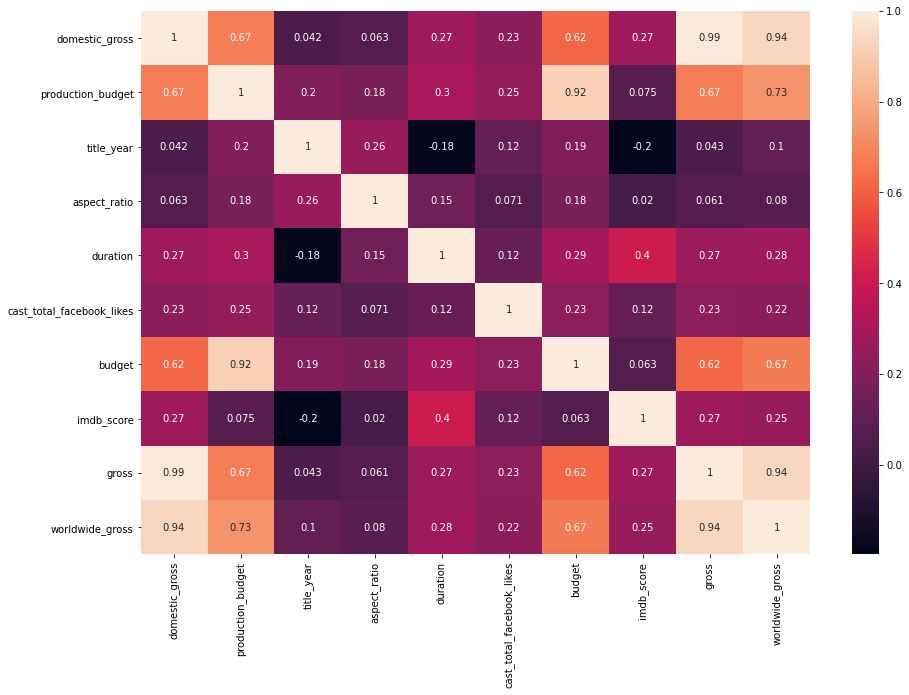

In [124]:
plt.figure(figsize=(15,10))
sns.heatmap(pd.concat([X,y], axis = 'columns').corr(), annot=True);

Ya que hay features que estan muy relacionados y dejan de ser independientes aplicaré PCA en dichos features

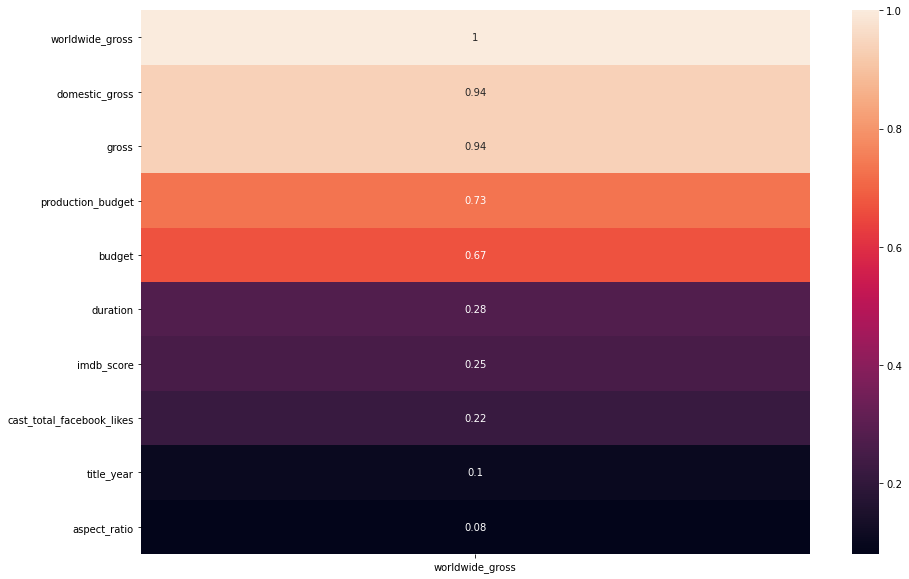

In [125]:
plt.figure(figsize=(15,10))
sns.heatmap(pd.concat([X,y], axis = 'columns').corr()[['worldwide_gross']].sort_values(by=['worldwide_gross'], ascending=False), annot=True);

In [126]:
gross_features = X[['domestic_gross','gross']]
budget_features = X[['budget','production_budget']]

In [127]:
pca_gross = PCA(n_components=1)
reduce_gross_features = pca_gross.fit_transform(gross_features)
pca_budget = PCA(n_components=1)
reduce_budget_features = pca_budget.fit_transform(budget_features)

In [128]:
print('La información que se puede explicar de las variables de gross es del',round(pca_gross.explained_variance_ratio_[0],4),'%')
print('La información que se puede explicar de las variables de budget es del',round(pca_budget.explained_variance_ratio_[0],4),'%')

La información que se puede explicar de las variables de gross es del 0.9968 %
La información que se puede explicar de las variables de budget es del 0.9587 %


In [129]:
X_copy = X.copy()

In [130]:
X_copy.drop(columns=['domestic_gross','gross','budget','production_budget'], inplace=True)
X_copy['gross'] = reduce_gross_features
X_copy['budget'] = reduce_budget_features

In [131]:
X = X_copy

In [132]:
X.head()

,title_year,aspect_ratio,duration,cast_total_facebook_likes,imdb_score,gross,budget
0,0.562549,-0.980456,3.328768,-0.336031,1.550898,15.081282,10.146503
1,1.073016,0.639770,2.920502,2.697668,4.336708,18.629327,9.065450
2,0.392393,0.753368,2.891058,2.152162,0.719321,5.572287,9.029756
3,1.073016,0.753368,1.869737,0.056559,0.407479,3.267459,8.116949
4,0.817782,0.753368,2.647886,5.491919,2.174581,8.496536,7.767466


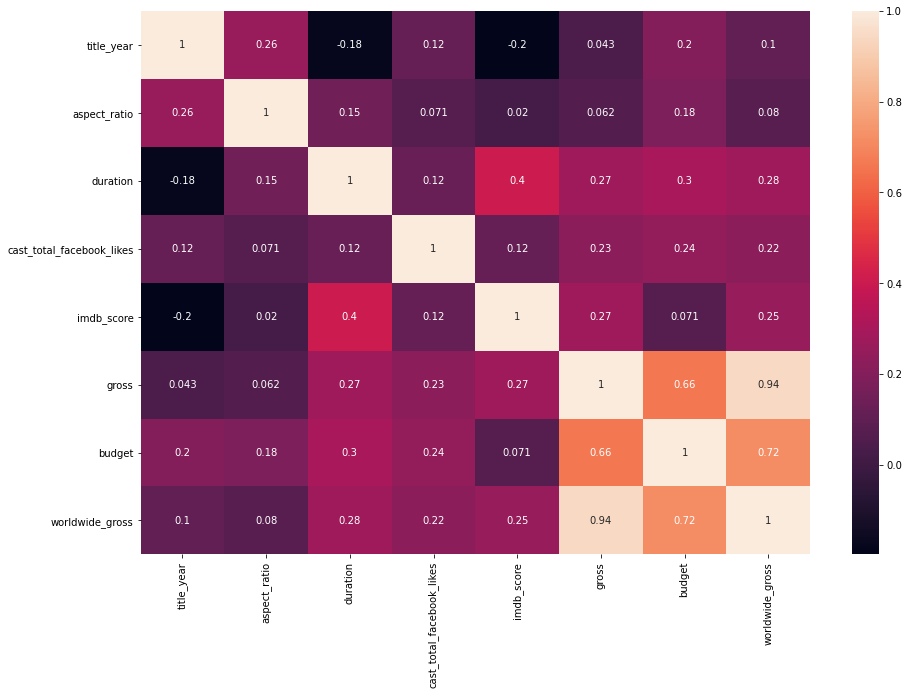

In [133]:
plt.figure(figsize=(15,10))
sns.heatmap(pd.concat([X,y], axis = 'columns').corr(), annot=True);

### Selecionar las mejores features con un algoritmo 

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [135]:
model = lr.fit(X_train,y_train)
predict = model.predict(X_test)

print('MSE :',mean_squared_error(predict,y_test))
print('R2:', model.score(X_test,y_test))

MSE : 2907677119484690.5
R2: 0.9231680997529368


In [136]:
mag = np.log10(np.abs(model.coef_))

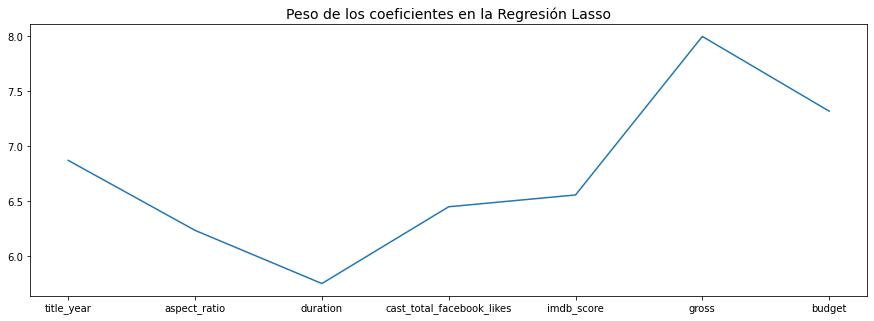

In [137]:
plt.figure(figsize=(15,5))
plt.title('Peso de los coeficientes en la Regresión Lasso', fontsize=14)
plt.plot(range(0,len(model.coef_)), mag)
plt.xticks(range(0,len(model.coef_)),X.columns);

In [138]:
selector = SelectKBest(mutual_info_regression, k=4 )
selector.fit(X,y)

SelectKBest(k=4, score_func=<function mutual_info_regression at 0x7f17388099d0>)

In [139]:
scores = selector.scores_

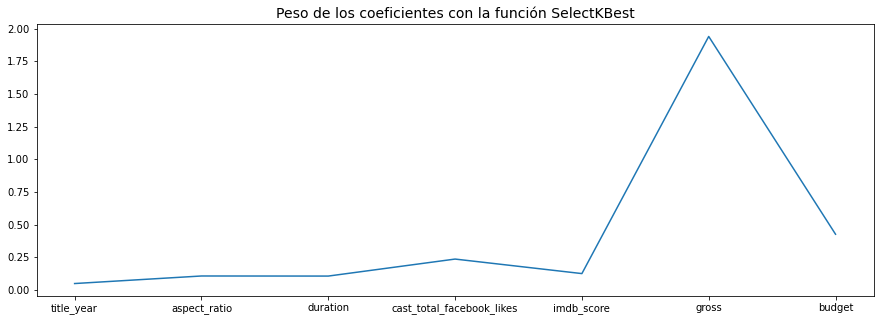

In [140]:
plt.figure(figsize=(15,5))
plt.title('Peso de los coeficientes con la función SelectKBest', fontsize=14)
plt.plot(range(0,len(model.coef_)), scores)
plt.xticks(range(0,len(model.coef_)),X.columns);

## Crear nuevas features 

In [141]:
df[str_columns].apply(pd.Series.nunique)

movie_title       4061
movie_link        4061
release_date      1906
color                2
language            21
country             43
genres             706
content_rating      12
plot_keywords     3145
director_name     1530
actor_1_name      1318
actor_2_name      1986
actor_3_name      2317
dtype: int64

La columna gross es una columna que no se tendría en el momento de usar el modelo, por lo cual hay que borrrala

In [142]:
categorical_f = df[['director_name','actor_1_name']]

In [143]:
categorical_f = categorical_f.fillna(0)

In [144]:
X_categorical =  pd.concat([X,categorical_f], axis='columns')

In [145]:
binary_encoder = ce.BinaryEncoder(cols=['director_name','actor_1_name'])
X_categorical = binary_encoder.fit_transform(X_categorical)

/home/cesar/anaconda3/envs/ia/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [146]:
print('No categorical x:',cross_val_score(lr, X, y, cv = KFold(shuffle=True, n_splits=6) ).mean())
print('Categorical X:   ',cross_val_score(lr, X_categorical, y, cv = KFold(shuffle=True, n_splits=6) ).mean())

No categorical x: 0.8976857148808676
Categorical X:    0.902729856215557


El score no aumentó, pero veamos si no aumentó porque las variables categorical no aportan información relevante para el modelo, o porque el modelo que estamos usando no es el más optimo

# Tunning

In [147]:
results = cross_validate(Lasso(),X,y, cv = KFold(shuffle=True, n_splits=6), return_train_score=True)
results_m = {}
for key, result in results.items():
    results_m[key] = np.mean(result)
    
print('No categorical:\n','Test_score:',results_m['test_score'],'\n','Train_score:',results_m['train_score'])

No categorical:
 Test_score: 0.8969877581187276 
 Train_score: 0.9009801558035334


In [148]:
results = cross_validate(Lasso(),X_categorical,y, cv = KFold(shuffle=True, n_splits=6), return_train_score=True)
results_m_categorical = {}
for key, result in results.items():
    results_m_categorical[key] = np.mean(result)
    
results_m_categorical
print('categorical:\n','Test_score:',results_m_categorical['test_score'],'\n','Train_score:',results_m_categorical['train_score'])

categorical:
 Test_score: 0.9026041087528824 
 Train_score: 0.9058062126585812


# Probar otros modelos

## K-Neighbors

### Validation curve

In [149]:
rango = np.arange(1,50,2)
rango.shape

(25,)

In [150]:
train_score, test_scores = validation_curve(
    KNeighborsRegressor(),
    X,
    y,
    param_name='n_neighbors',
    param_range=rango,
    cv = KFold(shuffle=True, n_splits=6)
)

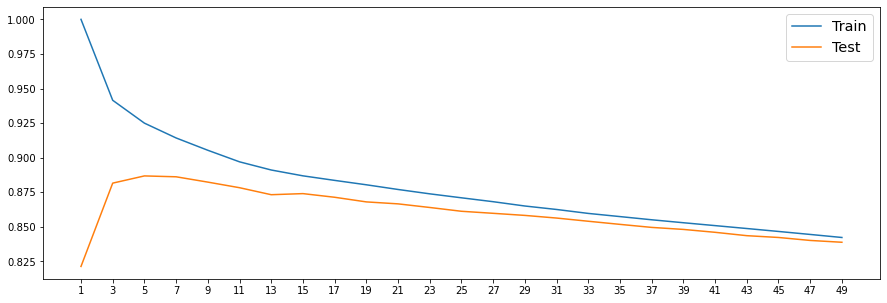

In [151]:
plt.figure(figsize=(15,5))
plt.plot(np.mean(train_score, axis=1), label = 'Train')
plt.plot(np.mean(test_scores, axis=1), label = 'Test')
plt.legend(fontsize = 'x-large')
plt.xticks(range(25),rango);

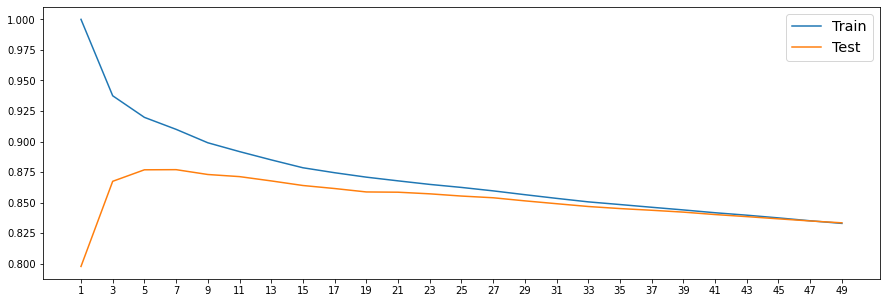

In [152]:
train_score_c, test_scores_c = validation_curve(
    KNeighborsRegressor(),
    X_categorical,
    y,
    param_name='n_neighbors',
    param_range=rango,
    cv = KFold(shuffle=True, n_splits=6)
)

plt.figure(figsize=(15,5))
plt.plot(np.mean(train_score_c, axis=1), label = 'Train')
plt.plot(np.mean(test_scores_c, axis=1), label = 'Test')
plt.legend(fontsize = 'x-large')
plt.xticks(range(25),rango);

In [153]:
print('Categorical:',sorted(list(zip(test_scores_c.mean(axis=1),rango)))[-1])

Categorical: (0.8769639907116881, 7)


In [154]:
print('No categorical:',sorted(list(zip(test_scores.mean(axis=1),rango)))[-1])

No categorical: (0.8868057836271604, 5)


In [155]:
sorted(list(zip(test_scores.mean(axis=1),rango)))[-1][1]

5

### Curva de aprendizaje

La curva de aprendizaje nos sirve para ver el modelo va aprendiendo a medida que se le otroga más datos

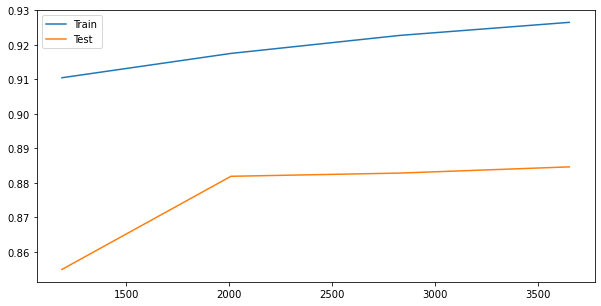

In [156]:
n_samples, train, test = learning_curve(
                                        KNeighborsRegressor(n_neighbors=sorted(list(zip(test_scores.mean(axis=1),rango)))[-1][1]), 
                                        X,
                                        y, 
                                        cv = KFold(shuffle=True, n_splits=10))

plt.figure(figsize=(10,5))
plt.plot(n_samples[1:], np.mean(train, axis=1)[1:], label='Train')
plt.plot(n_samples[1:], np.mean(test, axis=1)[1:], label='Test')
plt.legend();

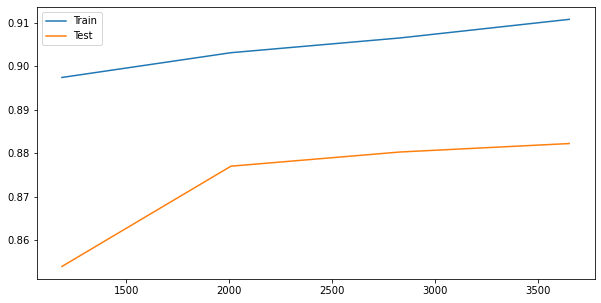

In [157]:
n_samples, train_c, test_c = learning_curve(
                                            KNeighborsRegressor(n_neighbors=sorted(list(zip(test_scores_c.mean(axis=1),rango)))[-1][1]), 
                                            X_categorical, 
                                            y, 
                                            cv = KFold(shuffle=True, n_splits=10))

plt.figure(figsize=(10,5))
plt.plot(n_samples[1:], np.mean(train_c, axis=1)[1:], label='Train')
plt.plot(n_samples[1:], np.mean(test_c, axis=1)[1:], label='Test')
plt.legend();

In [158]:
results = cross_validate(KNeighborsRegressor(n_neighbors=11),X_categorical,y, cv = KFold(shuffle=True, n_splits=6), return_train_score=True)
results_m = {}
for key, result in results.items():
    results_m[key] = np.mean(result)
    
results_m

{'fit_time': 0.002883275349934896,
 'score_time': 0.04305032889048258,
 'test_score': 0.8676260732613786,
 'train_score': 0.8910352040200186}

Se puede observar que la curva de aprendizaje esta en una tendencia de subida, esto quiere decir que si le suministramos mas datos tebdra un mejor rendimiento, pero al ser esto imposible porque ya no tenemos mas datos que suministrar, tenemos que buscar un mejor modelo para este problema

## Random Forest

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [160]:
results = cross_validate(RandomForestRegressor(),X_train,y_train, cv = KFold(shuffle=True, n_splits=6), return_train_score=True)
results_m = {}
for key, result in results.items():
    results_m[key] = np.mean(result)
    
results_m

{'fit_time': 0.7718958457310995,
 'score_time': 0.013223727544148764,
 'test_score': 0.8967638336416474,
 'train_score': 0.9849012687791387}

A diferencia de los otros modelos, aquí presentamos overfiting y no underfiting, lo cual se puede solucionar

In [188]:
param_range = {
 'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,110,120,130,None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': range(1,10),
 'min_samples_split': range(2,20),
 'n_estimators': range(100,2001,150)}

In [185]:
model = RandomForestRegressor(n_jobs=8)

In [ ]:
results = GridSearchCV(
    model,
    param_grid=param_range,
    cv = 5
)

results.fit(X_train,y_train)

In [161]:
rf_t = RandomForestRegressor(
    max_depth=80,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=2,
    bootstrap = True,
    n_estimators=400,
    n_jobs=8
)

In [162]:
results = cross_validate(rf_t,X_train,y_train, cv = KFold(shuffle=True, n_splits=6), return_train_score=True)
results_m = {}
for key, result in results.items():
    results_m[key] = np.mean(result)
    
results_m

{'fit_time': 0.3511740763982137,
 'score_time': 0.12115748723347981,
 'test_score': 0.8682932885012775,
 'train_score': 0.9183392360323587}

## Gradiant Boosted Trees

In [163]:
results = cross_validate(GradientBoostingRegressor(),X_train,y_train, cv = KFold(shuffle=True, n_splits=6), return_train_score=True)
results_m = {}
for key, result in results.items():
    results_m[key] = np.mean(result)
    
results_m

{'fit_time': 0.29730788866678876,
 'score_time': 0.0017628669738769531,
 'test_score': 0.9056538467849395,
 'train_score': 0.964430736136027}

In [177]:
results = cross_validate(GradientBoostingRegressor(),X_train,y_train, cv = 6, return_train_score=True)
results_m = {}
for key, result in results.items():
    results_m[key] = np.mean(result)
    
results_m

{'fit_time': 0.2904924154281616,
 'score_time': 0.0018770694732666016,
 'test_score': 0.8982664979573656,
 'train_score': 0.9644289773099111}

In [164]:
param_range = {'n_estimators':range(20,601,20)}

In [165]:
estimator = GradientBoostingRegressor(learning_rate=0.1,
                                     min_samples_split=500,
                                     min_samples_leaf=50,
                                     max_depth=8,
                                     max_features='sqrt',
                                     subsample=0.8,
                                     random_state=0)

In [173]:
gsearch = GridSearchCV(
    estimator,
    param_grid=param_range,
    cv = 6,
    scoring='r2'
)

In [174]:
gsearch.fit(X_train,y_train)

GridSearchCV(cv=6,
             estimator=GradientBoostingRegressor(max_depth=8,
                                                 max_features='sqrt',
                                                 min_samples_leaf=50,
                                                 min_samples_split=500,
                                                 n_estimators=240,
                                                 random_state=0,
                                                 subsample=0.8),
             param_grid={'n_estimators': range(20, 601, 20)}, scoring='r2')

In [175]:
gsearch.best_params_

{'n_estimators': 300}

In [176]:
final_results   = cross_validate(gsearch.best_estimator_, X_train, y_train, return_train_score=True, cv = 6) 

print('Train_score',np.mean(final_results['train_score']))
print('Test_score',np.mean(final_results['test_score']))

Train_score 0.9132570565157206
Test_score 0.8670769498199128


In [178]:
gsearch.best_estimator_.score(X_test,y_test)

0.8675213414352881

In [179]:
estimator = GradientBoostingRegressor(learning_rate=0.1,
                                     min_samples_split=500,
                                     min_samples_leaf=50,
                                     max_depth=8,
                                     max_features='sqrt',
                                     subsample=0.8,
                                     random_state=0,
                                     n_estimators=300)

In [180]:
estimator.fit(X_train,y_train)
estimator.score(X_test,y_test)

0.8675213414352881